# Dataset Preparation for First ICU Prediction

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
import torch
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader

from cnn.cnn_classifier.dataset import NoteDataset
from cnn.cnn_classifier.model import NoteClassifier
from cnn.args import args as cnn_args

from utils.embeddings import PretrainedEmbeddings
from utils.metrics import BinaryAvgMetrics
from utils.plots import *
from args import args

## 100 Run Performance Results

In [4]:
models = list(args.bc_threshold.keys())

bams = {}

for model in models:
  with open(args.workdir/model/'preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)
    
  bams[model] = BinaryAvgMetrics(targs, preds, probs)

all_metrics = {}

for key in bams.keys():
  all_metrics[key] = []
  for i in range(len(bams[key].get_avg_metrics())):
    all_metrics[key].append(bams[key].get_avg_metrics().iloc[i]['Value'])

metrics = pd.DataFrame(all_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])
metrics

,lr,rf,cnn,gbm
sensitivity,0.894,0.822,0.808,0.818
specificity,0.620,0.732,0.748,0.743
ppv,0.422,0.487,0.504,0.496
auroc,0.843,0.857,0.860,0.862
npv,0.950,0.930,0.928,0.929
f1,0.573,0.612,0.621,0.618


### Model Plots

In [5]:
model = 'gbm'
bams[model].get_avg_metrics()

,Value,Definition
sensitivity,0.818,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.743,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.496,"When it PREDICTS YES, how often is it correct?"
auroc,0.862,Indicates how well the model is capable of distinguishing between classes
npv,0.929,"When it PREDICTS NO, how often is it correct?"
f1,0.618,Harmonic mean of sensitivity and ppv


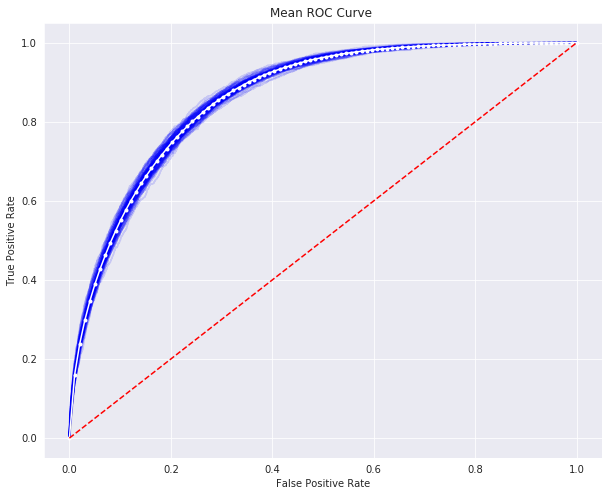

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bams[model].targs, bams[model].probs)

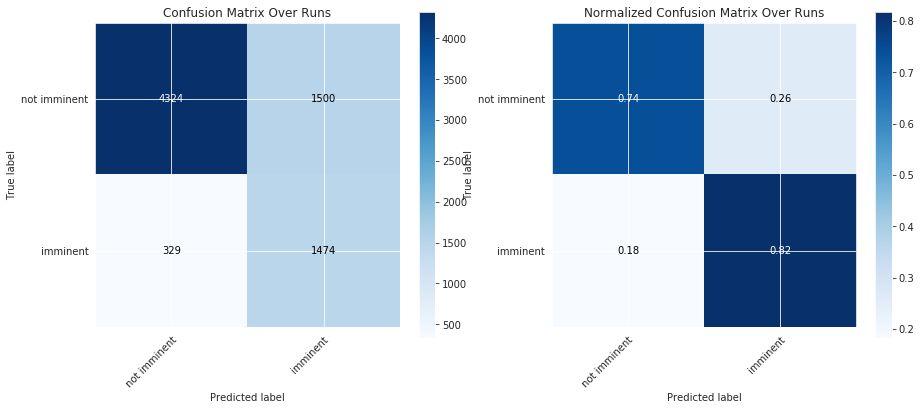

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bams[model].cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bams[model].cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Temporal Performance Analysis

In [8]:
df = pd.read_csv(args.dataset_csv, parse_dates=['admittime', 'dischtime', 'intime', 'charttime'])
df['relative_charttime'] = (df['charttime'] - df['intime'])
print(df.shape)
print(df.columns)

(75273, 22)
Index(['subject_id', 'hadm_id', 'icustay_id', 'admission_type', 'admittime',
       'dischtime', 'intime', 'charttime', 'adm_icu_period',
       'chart_icu_period', 'chartinterval', 'ethnicity', 'dob', 'gender',
       'admission_age', 'category', 'description', 'text', 'class_label',
       'note', 'scispacy_note', 'relative_charttime'],
      dtype='object')


In [9]:
interval=12
cutoff=20

### Logistic Regression

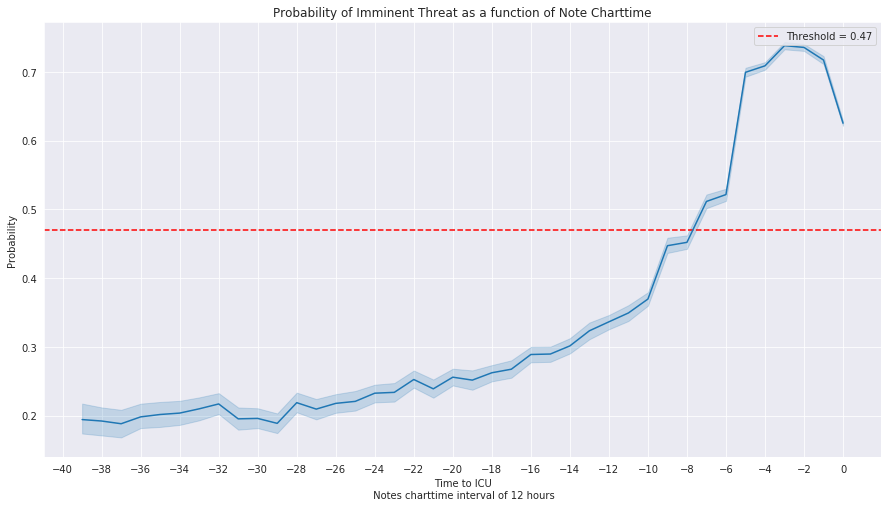

In [10]:
model = 'lr'

with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)

### Random Forest

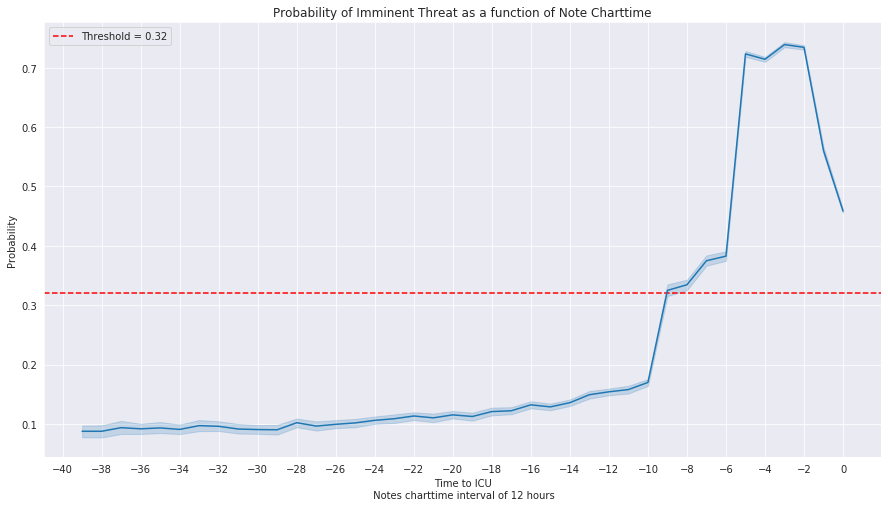

In [11]:
model = 'rf'

with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)  

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)

### CNN

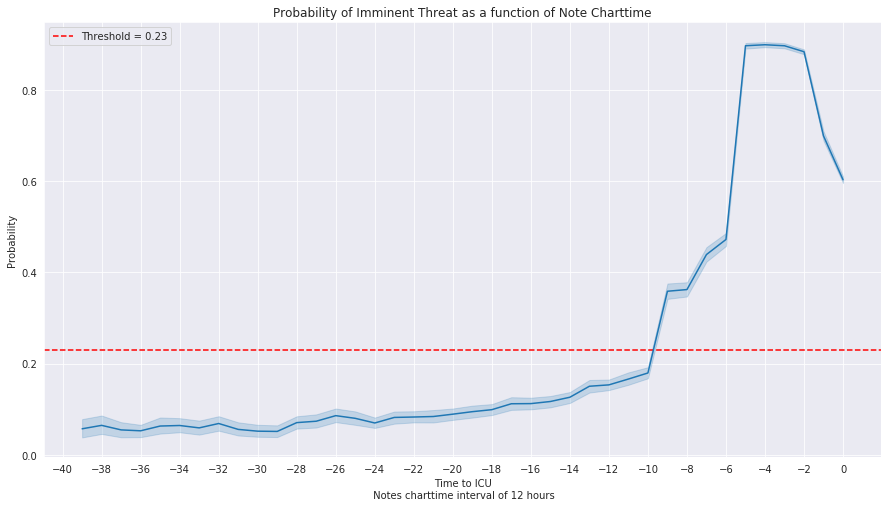

In [12]:
model = 'cnn'

try:
  prob = np.load(cnn_args.workdir/'probs.npy')
except FileNotFoundError:
  bs = 256
  ds = NoteDataset.load_data_and_vectorizer_from_file(df, cnn_args.workdir)
  dl = DataLoader(ds, bs)
  
  pe = PretrainedEmbeddings.from_file(cnn_args.emb_path)
  pe.make_custom_embeddings(ds.vectorizer.vocab.idx_token_bidict.values())
  
  with open(args.workdir/model/'full_data_model.pkl', 'rb') as f:
    state_dict = pickle.load(f)    
  classifier = NoteClassifier(cnn_args.emb_sz, len(ds.vectorizer.vocab), cnn_args.n_channels,\
                            cnn_args.hidden_dim, 1, dropout_p=cnn_args.dropout_p,\
                            emb_dropout=cnn_args.emb_dropout, pretrained=pe.custom_embeddings)
  classifier.load_state_dict(state_dict)
  p = []

  for x, _ in tqdm(dl):
    p.append(torch.sigmoid(classifier(x)).detach().numpy())
    
  prob = np.concatenate(p)
  np.save(cnn_args.workdir/'probabilities', prob)    

df['prob'] = prob

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)

### Gradient Boosting Machines

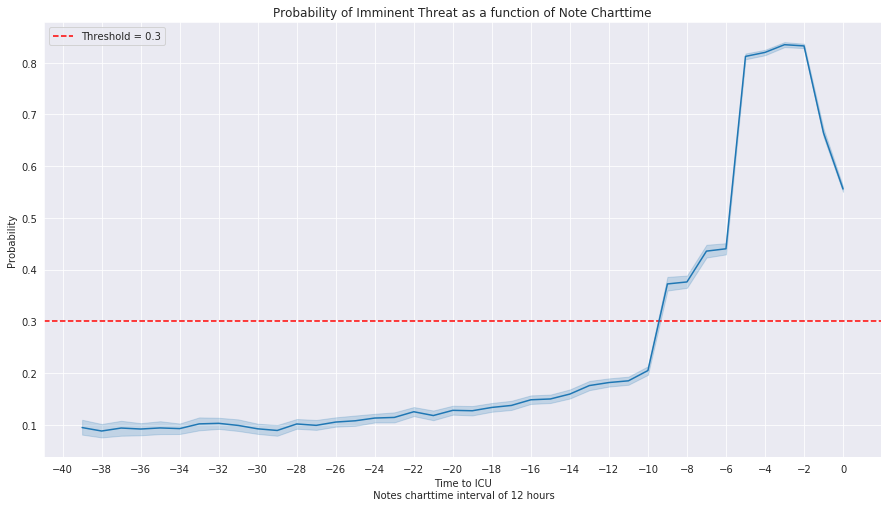

In [13]:
model = 'gbm'

with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)  

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)